In [4]:
from pathlib import Path
import os
import time
import json
import pandas as pd
import sys

# Add parent directory to path for imports
sys.path.insert(0, str(Path('..').resolve()))

In [5]:
canva_samples = Path('../datasets/canva/')

# Create a dataframe of all the files in the canva samples directory
canva_samples_df = pd.DataFrame(list(canva_samples.glob('**/*')), columns=['path'])

# Add a column for the filename
canva_samples_df['filename'] = canva_samples_df['path'].apply(lambda x: x.name)

In [33]:
def create_system_prompt(image_width: int, image_height: int) -> str:
    return f'''You are an expert graphic design analyst specializing in precise visual deconstruction.

Analyze the design image and return a JSON spec that captures EXACT positioning, colors, fonts, and styling.

CRITICAL REQUIREMENTS:
1. The input image is EXACTLY {image_width}x{image_height} pixels - measure all positions relative to this canvas size
2. Identify actual hex colors (e.g., #6a1b9a, not "purple") - be precise
3. Detect the actual font families used (common web fonts: Arial, Helvetica, Georgia, etc.)
4. Capture exact text content including proper capitalization and punctuation
5. Note all text styling: font-weight (normal, bold, 100-900), font-style (normal, italic), text-transform, text-decoration
6. For images/photos, provide detailed descriptions of the visual content
7. Identify background colors or gradients with exact hex values
8. Measure positions carefully - x,y is top-left corner of each element
9. Order nodes from back to front (background elements first, foreground elements last)
10. Return as few nodes as possible. Combine complex images into a single node.

Your output must be ONLY a valid JSON object with this exact structure:

{{
    "background_color": "#hexcolor",
    "has_background_image": true/false,
    "background_image_description": "detailed description if has_background_image is true, otherwise empty string",
    "nodes": [
        {{
            "type": "text",
            "text": "exact text content",
            "x": 0,
            "y": 0,
            "width": 0,
            "height": 0,
            "rotation": 0,
            "font-family": "actual font name",
            "font-size": 0,
            "color": "#hexcolor",
            "text-align": "left|center|right",
            "font-weight": "normal|bold|100-900",
            "font-style": "normal|italic",
            "text-decoration": "none|underline",
            "text-transform": "none|uppercase|lowercase|capitalize"
        }},
        {{
            "type": "image",
            "asset_description": "detailed description of the image content",
            "x": 0,
            "y": 0,
            "width": 0,
            "height": 0,
            "rotation": 0
        }}
    ]
}}

Be meticulous and accurate. The spec should enable faithful reconstruction of the design.'''


In [34]:
import litellm
from PIL import Image
from lib.utils import MIME_BY_SUFFIX, _to_data_url, _parse_json_str

# Load .env (force override so notebook doesn't keep an old key)
try:
    from dotenv import load_dotenv, find_dotenv
    load_dotenv(find_dotenv(), override=True)
except Exception:
    pass

# Ensure litellm uses the key from env
litellm.api_key = os.getenv('OPENAI_API_KEY')

# Hardcode reasoning/thinking config
THINKING = True
REASONING_EFFORT = 'medium'

# Spec generation -> one folder per source file, writing spec.json
OUTPUT_ROOT = Path('../datasets/canva_specs')
OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)
MODEL = os.getenv('OPENAI_MODEL', 'gpt-5')

DEBUG = False
if DEBUG:
    print((os.getenv("OPENAI_API_KEY", "")[-6:]), (litellm.api_key or "")[-6:])
    litellm._turn_on_debug()

instruction = (
    "Return ONLY a strict JSON object matching the schema from the system prompt. "
    "No code fences, no comments, no prose."
)

def describe_image_with_llm(image_path: Path, max_retries: int = 3, cooldown_s: float = 0.5) -> dict:
    # Get image dimensions
    with Image.open(image_path) as img:
        width, height = img.size
    
    # Create system prompt with actual dimensions
    system_prompt = create_system_prompt(width, height)
    
    data_url = _to_data_url(image_path)
    messages = [
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image_url", "image_url": {"url": data_url}},
            ],
        },
    ]
    llm_kwargs = {
        "temperature": 0,
        # "response_format": {"type": "json_object"},
        # "max_tokens": 2000,
        "reasoning_effort": REASONING_EFFORT,
    }

    last_err = None
    for attempt in range(1, max_retries + 1):
        try:
            resp = litellm.completion(
                model=MODEL,
                messages=messages,
                drop_params=True,  # drop unsupported params on providers that don't support them
                **llm_kwargs,
            )
            print(resp)
            text = resp["choices"][0]["message"]["content"]
            spec = _parse_json_str(text)
            
            # Append canvas dimensions to spec
            spec['canvas_width'] = width
            spec['canvas_height'] = height
            
            return spec
        except Exception as e:
            last_err = e
            print(f"  Attempt {attempt} failed: {e}")
            time.sleep(cooldown_s * attempt)
    raise last_err

# Filter to image files
img_df = canva_samples_df[canva_samples_df['path'].astype(str).str.lower().str.endswith(tuple(MIME_BY_SUFFIX.keys()))].copy()
print(f"Found {len(img_df)} image files")

# Generate specs in per-file folders
for i, p in enumerate(img_df['path'], start=1):
    p = Path(p)
    out_dir = (OUTPUT_ROOT / p.stem)
    out_dir.mkdir(parents=True, exist_ok=True)
    spec_path = out_dir / 'spec.json'
    error_path = out_dir / 'error.txt'

    if spec_path.exists():
        if i % 10 == 0:
            print(f"[{i}/{len(img_df)}] Skip existing: {out_dir.name}/spec.json")
        continue

    print(f"[{i}/{len(img_df)}] Processing {p.name}...")
    try:
        spec = describe_image_with_llm(p)
        with spec_path.open('w', encoding='utf-8') as f:
            json.dump(spec, f, ensure_ascii=False, indent=2)
        print(f"  ✓ Wrote {out_dir.name}/spec.json")
    except Exception as e:
        print(f"  ✗ ERROR: {e}")
        with error_path.open('w', encoding='utf-8') as f:
            f.write(str(e))
        continue

print('Done!')

Found 51 image files
[1/51] Processing 1257w-dnPJ18q1Q2E.webp...
ModelResponse(id='chatcmpl-CVQZ2tLAzZMEyBD3VGaKilULrChT7', created=1761606316, model='gpt-5-2025-08-07', object='chat.completion', system_fingerprint=None, choices=[Choices(finish_reason='stop', index=0, message=Message(content='{\n  "background_color": "#c5382f",\n  "has_background_image": true,\n  "background_image_description": "Full-bleed distressed red backdrop with scattered beige paint speckles and scratches, giving a vintage, gritty poster texture across the entire 1257x1600 canvas.",\n  "nodes": [\n    {\n      "type": "image",\n      "asset_description": "Back view of a woman with shoulder-length blonde hair wearing a brown corduroy jacket with white sherpa lining; she stands centered against the red background, occupying the lower half of the poster.",\n      "x": 0,\n      "y": 760,\n      "width": 1257,\n      "height": 840,\n      "rotation": 0\n    },\n    {\n      "type": "text",\n      "text": "FROM DIREC

Using sample: ../datasets/canva/1257w-dnPJ18q1Q2E.webp
Found 8 text boxes


/var/folders/2c/xdhs9djd73zb7hz3752jr1gh0000gn/T/ipykernel_12135/1095759733.py:110: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


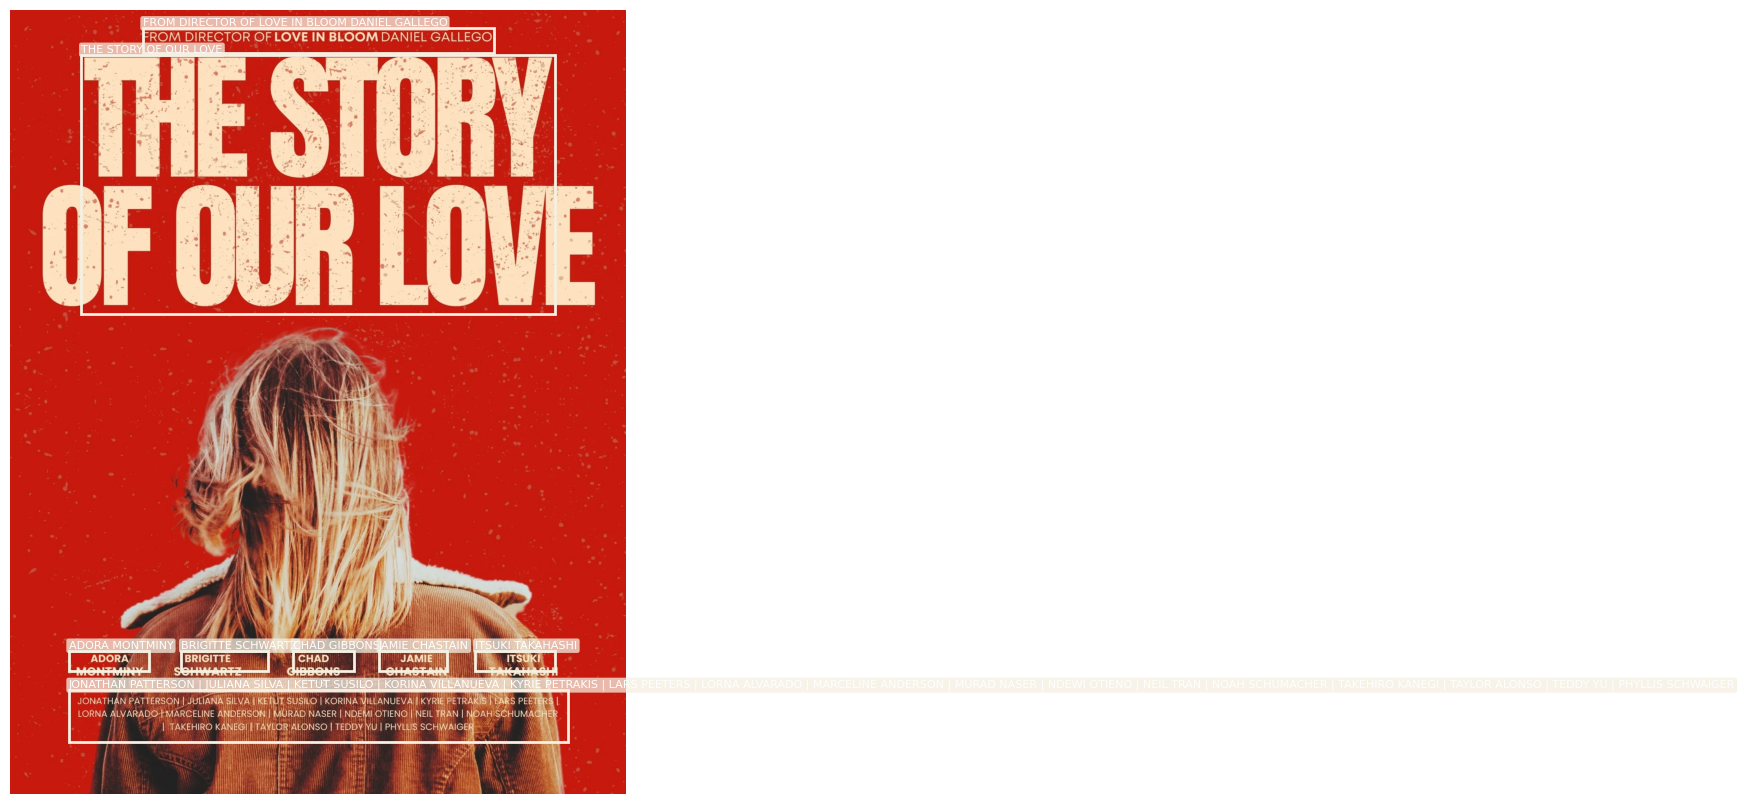

Saved: /Users/davidferris/Documents/Personal/Software/reconstruction-research/datasets/reconstructions/bboxes/1257w-dnPJ18q1Q2E_text_bboxes.png


In [ ]:
# New approach to deconstructing images

# Use gemini to extract text bounding boxes + labels from an image (single image demo)
import os
import json
import base64
from pathlib import Path

import litellm
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from lib.utils import _parse_json_str

# Ensure Gemini API key
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
if not GEMINI_API_KEY:
    try:
        from dotenv import load_dotenv, find_dotenv
        load_dotenv(find_dotenv(), override=False)
        GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
    except Exception:
        pass
assert GEMINI_API_KEY, "GEMINI_API_KEY not set"


def _image_to_data_url(image_path: Path) -> tuple[str, tuple[int, int]]:
    mime_by_suffix = {
        '.jpg': 'image/jpeg',
        '.jpeg': 'image/jpeg',
        '.png': 'image/png',
        '.webp': 'image/webp',
    }
    image_path = Path(image_path)
    with open(image_path, 'rb') as f:
        b64 = base64.b64encode(f.read()).decode('utf-8')
    with Image.open(image_path) as im:
        w, h = im.size
    mime = mime_by_suffix.get(image_path.suffix.lower(), 'image/png')
    return f"data:{mime};base64,{b64}", (w, h)


EXTRACT_PROMPT_TEMPLATE = (
    "Output a json list where each entry contains the 2D bounding box in \"box_2d\", "
    "the text content in \"label\", and the text color in \"color\". "
    "The bounding box coordinates should be normalized to the image dimensions (0-1000). "
    "Order of box_2d is [y_min, x_min, y_max, x_max]. "
    "Here’s what the response should look like: { \"box_2d\": [68, 75, 322, 408], \"label\": \"Start working out now\", \"color\": \"#0055b3\" }"
)


def gemini_extract_text_bboxes(image_path: Path, timeout: int = 60):
    data_url, _ = _image_to_data_url(image_path)
    resp = litellm.completion(
        model="gemini/gemini-2.5-pro",
        messages=[{
            "role": "user",
            "content": [
                {"type": "text", "text": EXTRACT_PROMPT_TEMPLATE},
                {"type": "image_url", "image_url": {"url": data_url}},
            ],
        }],
        api_key=GEMINI_API_KEY,
        timeout=timeout,
        temperature=0,
        drop_params=True,
    )
    text = resp.choices[0].message.content
    try:
        return _parse_json_str(text)
    except Exception as e:
        print("Raw model text:\n", text[:800])
        raise e


# --- Single image demo ---
# Pick one sample (adjust as needed)
sample_path = canva_samples_df['path'].iloc[0]
print("Using sample:", sample_path)

boxes_json = gemini_extract_text_bboxes(sample_path)
boxes = boxes_json if isinstance(boxes_json, list) else boxes_json.get('boxes', [])
print(f"Found {len(boxes)} text boxes")

# Draw boxes (denormalize 0-1000 coords to pixels)
with Image.open(sample_path) as im:
    W, H = im.size
    fig, ax = plt.subplots(figsize=(8, 8 * im.height / im.width))
    ax.imshow(im)
    ax.axis('off')

    def _hex_or_default(s):
        s = (s or '').strip()
        return s if isinstance(s, str) and s.startswith('#') else '#00e'

    for b in boxes:
        y0, x0, y1, x1 = b.get('box_2d', [0, 0, 0, 0])
        px0 = int(round(x0 * W / 1000)); py0 = int(round(y0 * H / 1000))
        px1 = int(round(x1 * W / 1000)); py1 = int(round(y1 * H / 1000))
        w = max(1, px1 - px0); h = max(1, py1 - py0)
        label = (b.get('label') or '').strip()
        color = _hex_or_default(b.get('color'))

        rect = Rectangle((px0, py0), w, h, fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(rect)
        if label:
            ax.text(px0, max(0, py0 - 4), label, fontsize=8, color='white',
                    bbox=dict(boxstyle='round,pad=0.2', fc=color, ec='none', alpha=0.75))

    plt.tight_layout()

out_dir = Path('../datasets/reconstructions/bboxes')
out_dir.mkdir(parents=True, exist_ok=True)
out_file = out_dir / f"{Path(sample_path).stem}_text_bboxes.png"
fig.savefig(out_file, dpi=150, bbox_inches='tight')
plt.show()
print("Saved:", out_file.resolve())
